# Exoplanet Detection CNN using Lightkurve Data
This notebook creates a CNN for exoplanet detection using individual lightkurve CSV files and KOI disposition data.

## Import Libraries

In [33]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


In [34]:
# Additional imports for hyperparameter tuning and advanced techniques
import keras_tuner as kt
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
import pickle
import matplotlib.pyplot as plt
from collections import Counter

## Data Loading and Exploration

In [35]:
# Define paths
lightkurve_data_path = 'lightkurve_data/'
koi_file_path = 'KOI Selected 2000 signals.csv'

# Load KOI disposition data
print("Loading KOI disposition data...")
koi_data = pd.read_csv(koi_file_path, comment='#')
print(f"KOI data shape: {koi_data.shape}")
print(f"Columns: {koi_data.columns.tolist()}")
print("\nFirst few rows:")
print(koi_data.head())

Loading KOI disposition data...
KOI data shape: (2000, 21)
Columns: ['kepid', 'koi_disposition', 'koi_period', 'koi_time0bk', 'koi_time0', 'koi_eccen', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_sma', 'koi_incl', 'koi_model_snr', 'koi_count', 'koi_bin_oedp_sig', 'koi_datalink_dvr', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_sage', 'koi_kepmag']

First few rows:
      kepid koi_disposition  koi_period  koi_time0bk    koi_time0  koi_eccen  \
0   5560831  FALSE POSITIVE    0.867721   132.161646  2454965.162          0   
1   7899070       CANDIDATE  126.445127   166.499980  2454999.500          0   
2   9656397  FALSE POSITIVE  204.741048   202.871314  2455035.871          0   
3  10166274       CANDIDATE    3.353732   134.869597  2454967.870          0   
4   7049486  FALSE POSITIVE   26.718418   138.051803  2454971.052          0   

   koi_impact  koi_duration  koi_depth  koi_sma  ...  koi_model_snr  \
0       0.987       4.87830    97653.0   0.0173  ...          587.

In [36]:
# Check disposition distribution
print("\nDisposition distribution:")
print(koi_data['koi_disposition'].value_counts())

# Check for missing values
print("\nMissing values:")
print(koi_data.isnull().sum())


Disposition distribution:
koi_disposition
FALSE POSITIVE    1000
CANDIDATE         1000
Name: count, dtype: int64

Missing values:
kepid                  0
koi_disposition        0
koi_period             0
koi_time0bk            0
koi_time0              0
koi_eccen              0
koi_impact             0
koi_duration           0
koi_depth              0
koi_sma                0
koi_incl               0
koi_model_snr          0
koi_count              0
koi_bin_oedp_sig      32
koi_datalink_dvr      19
koi_steff              0
koi_slogg              0
koi_srad               0
koi_smass              0
koi_sage            2000
koi_kepmag             0
dtype: int64
kepid                  0
koi_disposition        0
koi_period             0
koi_time0bk            0
koi_time0              0
koi_eccen              0
koi_impact             0
koi_duration           0
koi_depth              0
koi_sma                0
koi_incl               0
koi_model_snr          0
koi_count              0
koi_b

In [37]:
# Get list of all lightkurve CSV files
lightkurve_files = glob.glob(os.path.join(lightkurve_data_path, 'kepler_*_lightkurve.csv'))
print(f"Total lightkurve files found: {len(lightkurve_files)}")

# Extract Kepler IDs from filenames
kepler_ids_from_files = []
for file in lightkurve_files:
    filename = os.path.basename(file)
    # Extract ID from filename: kepler_ID_lightkurve.csv
    kepler_id = filename.split('_')[1]
    kepler_ids_from_files.append(int(kepler_id))

print(f"Sample Kepler IDs from files: {kepler_ids_from_files[:5]}")
print(f"Total unique Kepler IDs from files: {len(set(kepler_ids_from_files))}")

Total lightkurve files found: 1207
Sample Kepler IDs from files: [10000490, 10002261, 10002866, 10004738, 10006096]
Total unique Kepler IDs from files: 1207


In [38]:
# Check overlap between file IDs and KOI data
koi_kepler_ids = set(koi_data['kepid'].values)
file_kepler_ids = set(kepler_ids_from_files)

overlapping_ids = koi_kepler_ids.intersection(file_kepler_ids)
print(f"KOI Kepler IDs: {len(koi_kepler_ids)}")
print(f"File Kepler IDs: {len(file_kepler_ids)}")
print(f"Overlapping IDs: {len(overlapping_ids)}")

# Show sample of overlapping IDs
print(f"\nSample overlapping IDs: {list(overlapping_ids)[:10]}")

KOI Kepler IDs: 1839
File Kepler IDs: 1207
Overlapping IDs: 1207

Sample overlapping IDs: [11968513, 10166274, 8957954, 6922244, 4769799, 6062088, 3239945, 6103049, 11147276, 9166862]


## Data Processing Functions

In [39]:
def load_lightkurve_data(file_path, max_length=3000):
    """
    Load and preprocess a single lightkurve CSV file.
    Returns normalized flux data as a time series.
    """
    try:
        df = pd.read_csv(file_path)
        
        # Use the main flux column (either 'flux' or 'pdcsap_flux')
        if 'pdcsap_flux' in df.columns:
            flux_data = df['pdcsap_flux'].dropna().values
        elif 'flux' in df.columns:
            flux_data = df['flux'].dropna().values
        else:
            print(f"Warning: No flux column found in {file_path}")
            return None
        
        # Remove outliers (simple method: remove values beyond 3 sigma)
        mean_flux = np.mean(flux_data)
        std_flux = np.std(flux_data)
        flux_data = flux_data[np.abs(flux_data - mean_flux) < 3 * std_flux]
        
        # Normalize the flux data
        if len(flux_data) > 0:
            flux_data = (flux_data - np.mean(flux_data)) / np.std(flux_data)
        
        # Pad or truncate to fixed length
        if len(flux_data) > max_length:
            flux_data = flux_data[:max_length]
        elif len(flux_data) < max_length:
            flux_data = np.pad(flux_data, (0, max_length - len(flux_data)), mode='constant', constant_values=0)
        
        return flux_data
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

Testing with: lightkurve_data\kepler_10000490_lightkurve.csv
Loaded data shape: (3000,)
Data stats - Mean: -0.0533, Std: 1.1241
Loaded data shape: (3000,)
Data stats - Mean: -0.0533, Std: 1.1241


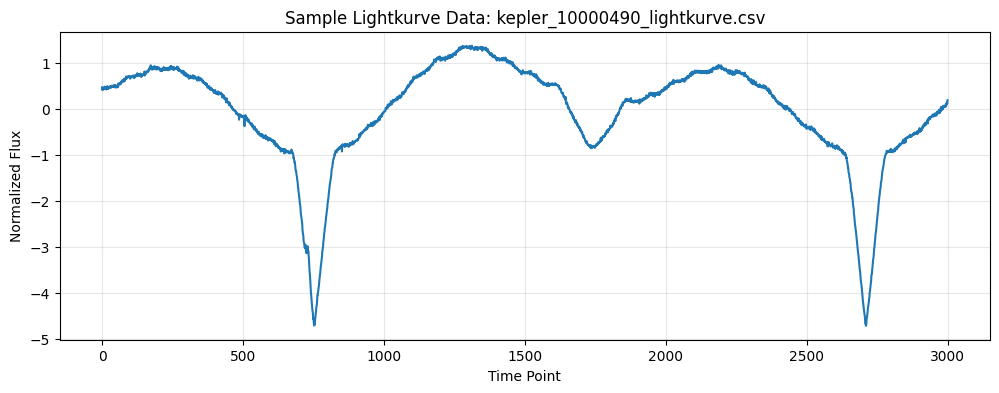

In [40]:
# Test the loading function with a sample file
sample_file = lightkurve_files[0]
print(f"Testing with: {sample_file}")
sample_data = load_lightkurve_data(sample_file)
if sample_data is not None:
    print(f"Loaded data shape: {sample_data.shape}")
    print(f"Data stats - Mean: {np.mean(sample_data):.4f}, Std: {np.std(sample_data):.4f}")
    
    # Plot the sample data
    plt.figure(figsize=(12, 4))
    plt.plot(sample_data)
    plt.title(f"Sample Lightkurve Data: {os.path.basename(sample_file)}")
    plt.xlabel("Time Point")
    plt.ylabel("Normalized Flux")
    plt.grid(True, alpha=0.3)
    plt.show()

## Dataset Preparation

In [41]:
def create_dataset_from_lightkurve():
    """
    Create the complete dataset by loading all lightkurve files that have corresponding KOI dispositions.
    """
    X_data = []
    y_labels = []
    kepler_ids_used = []
    failed_loads = 0
    
    print("Loading lightkurve data for overlapping Kepler IDs...")
    
    for i, kepler_id in enumerate(overlapping_ids):
        if i % 100 == 0:
            print(f"Processed {i}/{len(overlapping_ids)} files...")
        
        # Construct filename
        filename = f"kepler_{kepler_id}_lightkurve.csv"
        file_path = os.path.join(lightkurve_data_path, filename)
        
        # Load the lightkurve data
        flux_data = load_lightkurve_data(file_path)
        
        if flux_data is not None:
            # Get the disposition for this Kepler ID
            disposition = koi_data[koi_data['kepid'] == kepler_id]['koi_disposition'].iloc[0]
            
            X_data.append(flux_data)
            y_labels.append(disposition)
            kepler_ids_used.append(kepler_id)
        else:
            failed_loads += 1
    
    print(f"\nDataset creation complete!")
    print(f"Successfully loaded: {len(X_data)} files")
    print(f"Failed to load: {failed_loads} files")
    
    return np.array(X_data), np.array(y_labels), np.array(kepler_ids_used)

# Create the dataset
X, y, kepler_ids_used = create_dataset_from_lightkurve()

Loading lightkurve data for overlapping Kepler IDs...
Processed 0/1207 files...
Processed 100/1207 files...
Processed 100/1207 files...
Processed 200/1207 files...
Processed 200/1207 files...
Processed 300/1207 files...
Processed 300/1207 files...
Processed 400/1207 files...
Processed 400/1207 files...
Processed 500/1207 files...
Processed 500/1207 files...
Processed 600/1207 files...
Processed 600/1207 files...
Processed 700/1207 files...
Processed 700/1207 files...
Processed 800/1207 files...
Processed 800/1207 files...
Processed 900/1207 files...
Processed 900/1207 files...
Processed 1000/1207 files...
Processed 1000/1207 files...
Processed 1100/1207 files...
Processed 1100/1207 files...
Processed 1200/1207 files...

Dataset creation complete!
Successfully loaded: 1207 files
Failed to load: 0 files
Processed 1200/1207 files...

Dataset creation complete!
Successfully loaded: 1207 files
Failed to load: 0 files


In [42]:
# Check the dataset
print(f"Final dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Kepler IDs used: {len(kepler_ids_used)}")

# Check label distribution
unique_labels, label_counts = np.unique(y, return_counts=True)
print("\nLabel distribution:")
for label, count in zip(unique_labels, label_counts):
    print(f"{label}: {count} ({count/len(y)*100:.1f}%)")

Final dataset shape: (1207, 3000)
Labels shape: (1207,)
Kepler IDs used: 1207

Label distribution:
CANDIDATE: 550 (45.6%)
FALSE POSITIVE: 657 (54.4%)


In [43]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print(f"Label encoding mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i}: {label}")

print(f"\nEncoded labels shape: {y_encoded.shape}")
print(f"Categorical labels shape: {y_categorical.shape}")

Label encoding mapping:
0: CANDIDATE
1: FALSE POSITIVE

Encoded labels shape: (1207,)
Categorical labels shape: (1207, 2)


## Train-Test Split and Metadata Export

In [44]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, y_cat_train, y_cat_test, ids_train, ids_test = train_test_split(
    X, y_encoded, y_categorical, kepler_ids_used, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Check distribution in splits
print("\nTraining set distribution:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for label_idx, count in zip(train_unique, train_counts):
    label_name = label_encoder.inverse_transform([label_idx])[0]
    print(f"{label_name}: {count} ({count/len(y_train)*100:.1f}%)")

print("\nTesting set distribution:")
test_unique, test_counts = np.unique(y_test, return_counts=True)
for label_idx, count in zip(test_unique, test_counts):
    label_name = label_encoder.inverse_transform([label_idx])[0]
    print(f"{label_name}: {count} ({count/len(y_test)*100:.1f}%)")

Training set: 965 samples
Testing set: 242 samples

Training set distribution:
CANDIDATE: 440 (45.6%)
FALSE POSITIVE: 525 (54.4%)

Testing set distribution:
CANDIDATE: 110 (45.5%)
FALSE POSITIVE: 132 (54.5%)


In [45]:
# Create and save metadata CSV files as requested
print("Creating metadata CSV files...")

# Training data metadata
train_metadata = pd.DataFrame({
    'kepid': ids_train,
    'koi_disposition': label_encoder.inverse_transform(y_train)
})
train_metadata.to_csv('lightkurve_train_metadata.csv', index=False)
print(f"Saved training metadata: lightkurve_train_metadata.csv ({len(train_metadata)} records)")

# Testing data metadata
test_metadata = pd.DataFrame({
    'kepid': ids_test,
    'koi_disposition': label_encoder.inverse_transform(y_test)
})
test_metadata.to_csv('lightkurve_test_metadata.csv', index=False)
print(f"Saved testing metadata: lightkurve_test_metadata.csv ({len(test_metadata)} records)")

# Display first few rows of each metadata file
print("\nTraining metadata sample:")
print(train_metadata.head())
print("\nTesting metadata sample:")
print(test_metadata.head())

Creating metadata CSV files...
Saved training metadata: lightkurve_train_metadata.csv (965 records)
Saved testing metadata: lightkurve_test_metadata.csv (242 records)

Training metadata sample:
     kepid koi_disposition
0  3247294  FALSE POSITIVE
1  6672229  FALSE POSITIVE
2  5467102  FALSE POSITIVE
3  3632418       CANDIDATE
4  7691527  FALSE POSITIVE

Testing metadata sample:
      kepid koi_disposition
0  10904857       CANDIDATE
1   9652632  FALSE POSITIVE
2   6781535  FALSE POSITIVE
3   6362874       CANDIDATE
4   6266741       CANDIDATE
      kepid koi_disposition
0  10904857       CANDIDATE
1   9652632  FALSE POSITIVE
2   6781535  FALSE POSITIVE
3   6362874       CANDIDATE
4   6266741       CANDIDATE


## Data Visualization

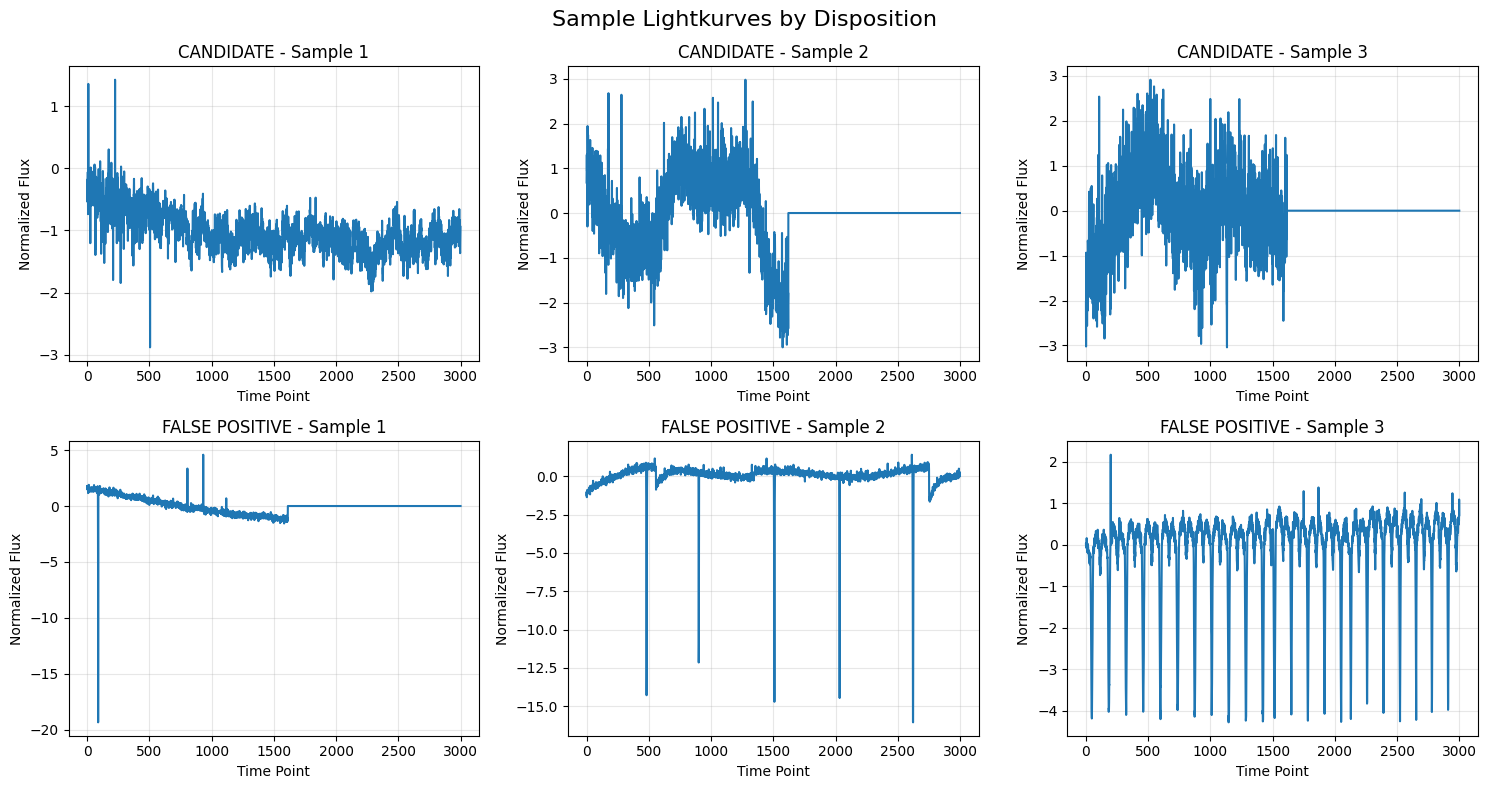

In [46]:
# Plot some sample lightkurves for each class
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Sample Lightkurves by Disposition', fontsize=16)

for class_idx, class_name in enumerate(label_encoder.classes_):
    # Get samples from this class
    class_mask = y_train == class_idx
    class_samples = X_train[class_mask]
    
    for i in range(3):
        if i < len(class_samples):
            axes[class_idx, i].plot(class_samples[i])
            axes[class_idx, i].set_title(f'{class_name} - Sample {i+1}')
            axes[class_idx, i].set_xlabel('Time Point')
            axes[class_idx, i].set_ylabel('Normalized Flux')
            axes[class_idx, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## CNN Model Architecture

In [47]:
# Reshape data for CNN (add channel dimension)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Reshaped training data: {X_train_reshaped.shape}")
print(f"Reshaped testing data: {X_test_reshaped.shape}")

Reshaped training data: (965, 3000, 1)
Reshaped testing data: (242, 3000, 1)


In [48]:
def create_advanced_cnn_model(input_shape, num_classes, hp=None):
    """
    Create an advanced CNN model with optional hyperparameter tuning.
    Includes residual connections, attention mechanisms, and advanced regularization.
    """
    if hp is not None:
        # Hyperparameter tuning mode
        filters_1 = hp.Int('filters_1', min_value=16, max_value=64, step=16)
        filters_2 = hp.Int('filters_2', min_value=32, max_value=128, step=32)
        filters_3 = hp.Int('filters_3', min_value=64, max_value=256, step=64)
        dense_units_1 = hp.Int('dense_1', min_value=128, max_value=512, step=128)
        dense_units_2 = hp.Int('dense_2', min_value=64, max_value=256, step=64)
        dropout_rate = hp.Float('dropout', min_value=0.2, max_value=0.6, step=0.1)
        l2_reg = hp.Float('l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG')
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    else:
        # Default values for non-tuning mode
        filters_1, filters_2, filters_3 = 32, 64, 128
        dense_units_1, dense_units_2 = 256, 128
        dropout_rate = 0.4
        l2_reg = 1e-4
        learning_rate = 0.001
    
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # First convolutional block with residual connection
    x = layers.Conv1D(filters_1, 7, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters_1, 7, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Residual connection for first block
    shortcut1 = layers.Conv1D(filters_1, 1, padding='same')(inputs)
    x = layers.Add()([x, shortcut1])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(3)(x)
    x = layers.Dropout(dropout_rate * 0.5)(x)
    
    # Second convolutional block with residual connection
    shortcut2 = layers.Conv1D(filters_2, 1, padding='same')(x)
    x = layers.Conv1D(filters_2, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters_2, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut2])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(3)(x)
    x = layers.Dropout(dropout_rate * 0.6)(x)
    
    # Third convolutional block with attention mechanism
    shortcut3 = layers.Conv1D(filters_3, 1, padding='same')(x)
    x = layers.Conv1D(filters_3, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters_3, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut3])
    x = layers.Activation('relu')(x)
    
    # Attention mechanism
    attention = layers.Dense(filters_3, activation='tanh')(x)
    attention = layers.Dense(1, activation='sigmoid')(attention)
    x = layers.Multiply()([x, attention])
    
    # Global pooling with both max and average
    max_pool = layers.GlobalMaxPooling1D()(x)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    x = layers.Concatenate()([max_pool, avg_pool])
    x = layers.Dropout(dropout_rate)(x)
    
    # Dense layers with regularization
    x = layers.Dense(dense_units_1, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Dense(dense_units_2, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate * 0.8)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax',
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model, learning_rate if hp is not None else (model, learning_rate)

# Test the advanced model without hyperparameter tuning
input_shape = (X_train_reshaped.shape[1], 1)
num_classes = len(label_encoder.classes_)

advanced_model, lr = create_advanced_cnn_model(input_shape, num_classes)
print(f"Advanced Model input shape: {input_shape}")
print(f"Number of classes: {num_classes}")
print(f"Model parameters: {advanced_model.count_params():,}")
advanced_model.summary()

Advanced Model input shape: (3000, 1)
Number of classes: 2
Model parameters: 241,699


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 3000, 32)  │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3000, 32)  │        128 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 3000, 32)  │      7,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3000, 32)  │        128 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 3000, 32)  │         64 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 3000, 32)  │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 3000, 32)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 1000, 32)  │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1000, 32)  │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 1000, 64)  │     10,304 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 64)  │        256 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1000, 64)  │     20,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 64)  │        256 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 1000, 64)  │      2,112 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1000, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1000, 64)  │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 333, 64)   │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 333, 64)   │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 241,699 (944.14 KB)

 Trainable params: 240,035 (937.64 KB)

 Non-trainable params: 1,664 (6.50 KB)

## Hyperparameter Tuning Setup

In [49]:
class ExoplanetHyperModel(kt.HyperModel):
    """
    Hypermodel class for Keras Tuner to optimize CNN architecture and hyperparameters.
    """
    
    def __init__(self, input_shape, num_classes, class_weight_dict):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.class_weight_dict = class_weight_dict
    
    def build(self, hp):
        """Build model with hyperparameters."""
        model, learning_rate = create_advanced_cnn_model(self.input_shape, self.num_classes, hp)
        
        # Compile with tuned hyperparameters
        optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
        
        if optimizer_choice == 'adam':
            optimizer = optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_choice == 'rmsprop':
            optimizer = optimizers.RMSprop(learning_rate=learning_rate)
        else:
            optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
        
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        """Custom fit method with early stopping and class weights."""
        # Add early stopping
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=0
        )
        
        # Add learning rate reduction
        lr_scheduler = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=0
        )
        
        kwargs['callbacks'] = [early_stopping, lr_scheduler]
        kwargs['class_weight'] = self.class_weight_dict
        kwargs['epochs'] = min(kwargs.get('epochs', 50), 50)  # Limit epochs for tuning
        kwargs['verbose'] = 0  # Reduce output during tuning
        
        return model.fit(*args, **kwargs)

# Initialize the hypermodel
hypermodel = ExoplanetHyperModel(input_shape, num_classes, class_weight_dict)

print("Hypermodel initialized successfully!")

Hypermodel initialized successfully!


In [51]:
# Configure hyperparameter tuning
tuning_strategy = 'random'  # Options: 'random', 'bayesian', 'hyperband'

if tuning_strategy == 'random':
    tuner = kt.RandomSearch(
        hypermodel,
        objective='val_accuracy',
        max_trials=20,  # Number of different hyperparameter combinations to try
        directory='hyperparameter_tuning',
        project_name='exoplanet_cnn_tuning',
        overwrite=True
    )
elif tuning_strategy == 'bayesian':
    tuner = kt.BayesianOptimization(
        hypermodel,
        objective='val_accuracy',
        max_trials=15,
        directory='hyperparameter_tuning',
        project_name='exoplanet_cnn_tuning',
        overwrite=True
    )
else:  # hyperband
    tuner = kt.Hyperband(
        hypermodel,
        objective='val_accuracy',
        max_epochs=30,
        factor=3,
        directory='hyperparameter_tuning',
        project_name='exoplanet_cnn_tuning',
        overwrite=True
    )

print(f"Tuner configured with {tuning_strategy} search strategy")
print(f"Max trials: {getattr(tuner, 'max_trials', 'N/A')}")

# Display search space
tuner.search_space_summary()

Tuner configured with random search strategy
Max trials: N/A
Search space summary
Default search space size: 9
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
filters_3 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
dense_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
dense_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
l2_reg (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.0001

## Hyperparameter Tuning Execution

In [52]:
# Run hyperparameter tuning
print("Starting hyperparameter tuning...")
print("This may take a while depending on the number of trials and data size.")
print("=" * 60)

# Create a smaller validation split from training data for faster tuning
X_train_tune, X_val_tune, y_train_tune, y_val_tune = train_test_split(
    X_train_reshaped, y_cat_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"Tuning training set: {X_train_tune.shape[0]} samples")
print(f"Tuning validation set: {X_val_tune.shape[0]} samples")

# Start the search
tuner.search(
    X_train_tune, y_train_tune,
    epochs=30,  # Reduced epochs for faster tuning
    validation_data=(X_val_tune, y_val_tune),
    batch_size=32,
    verbose=1
)

print("\nHyperparameter tuning completed!")
print("=" * 60)

Trial 20 Complete [00h 11m 20s]
val_accuracy: 0.8549222946166992

Best val_accuracy So Far: 0.8963730335235596
Total elapsed time: 01h 47m 36s

Hyperparameter tuning completed!


In [54]:
# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters Found:")
print("=" * 40)
print(f"Filters 1: {best_hps.get('filters_1')}")
print(f"Filters 2: {best_hps.get('filters_2')}")
print(f"Filters 3: {best_hps.get('filters_3')}")
print(f"Dense 1: {best_hps.get('dense_1')}")
print(f"Dense 2: {best_hps.get('dense_2')}")
print(f"Dropout: {best_hps.get('dropout')}")
print(f"L2 Regularization: {best_hps.get('l2_reg')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Optimizer: {best_hps.get('optimizer')}")

# Save best hyperparameters
best_hp_dict = {}
for key in ['filters_1', 'filters_2', 'filters_3', 'dense_1', 'dense_2', 
           'dropout', 'l2_reg', 'learning_rate', 'optimizer']:
    best_hp_dict[key] = best_hps.get(key)

import json
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hp_dict, f, indent=2)

print(f"\nBest hyperparameters saved to: best_hyperparameters.json")

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
print(f"\nBest model obtained with validation accuracy: {max(tuner.oracle.get_best_trials(1)[0].metrics.get_history('val_accuracy')):.4f}")

Best Hyperparameters Found:
Filters 1: 64
Filters 2: 32
Filters 3: 64
Dense 1: 128
Dense 2: 256
Dropout: 0.2
L2 Regularization: 2.330588876064649e-05
Learning Rate: 0.003437632621059782
Optimizer: rmsprop

Best hyperparameters saved to: best_hyperparameters.json


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'hyperparameter_tuning\exoplanet_cnn_tuning\trial_03\checkpoint.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Training Best Model with Full Dataset

In [55]:
# Build the best model with optimized hyperparameters
print("Building optimized model with best hyperparameters...")

# Create model with best hyperparameters (without hp parameter)
optimized_model, opt_lr = create_advanced_cnn_model(input_shape, num_classes)

# Manually set the best hyperparameters found
# Note: Since we can't pass hp to the function in non-tuning mode, 
# we'll create a new model with the best parameters

def create_best_model(input_shape, num_classes, best_hps):
    """Create model with the best found hyperparameters."""
    filters_1 = best_hps.get('filters_1', 32)
    filters_2 = best_hps.get('filters_2', 64) 
    filters_3 = best_hps.get('filters_3', 128)
    dense_units_1 = best_hps.get('dense_1', 256)
    dense_units_2 = best_hps.get('dense_2', 128)
    dropout_rate = best_hps.get('dropout', 0.4)
    l2_reg = best_hps.get('l2_reg', 1e-4)
    
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # First convolutional block with residual connection
    x = layers.Conv1D(filters_1, 7, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters_1, 7, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Residual connection for first block
    shortcut1 = layers.Conv1D(filters_1, 1, padding='same')(inputs)
    x = layers.Add()([x, shortcut1])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(3)(x)
    x = layers.Dropout(dropout_rate * 0.5)(x)
    
    # Second convolutional block with residual connection
    shortcut2 = layers.Conv1D(filters_2, 1, padding='same')(x)
    x = layers.Conv1D(filters_2, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters_2, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut2])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(3)(x)
    x = layers.Dropout(dropout_rate * 0.6)(x)
    
    # Third convolutional block with attention mechanism
    shortcut3 = layers.Conv1D(filters_3, 1, padding='same')(x)
    x = layers.Conv1D(filters_3, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters_3, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut3])
    x = layers.Activation('relu')(x)
    
    # Attention mechanism
    attention = layers.Dense(filters_3, activation='tanh')(x)
    attention = layers.Dense(1, activation='sigmoid')(attention)
    x = layers.Multiply()([x, attention])
    
    # Global pooling with both max and average
    max_pool = layers.GlobalMaxPooling1D()(x)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    x = layers.Concatenate()([max_pool, avg_pool])
    x = layers.Dropout(dropout_rate)(x)
    
    # Dense layers with regularization
    x = layers.Dense(dense_units_1, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Dense(dense_units_2, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate * 0.8)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax',
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    
    return keras.Model(inputs=inputs, outputs=outputs)

# Create the optimized model
optimized_model = create_best_model(input_shape, num_classes, best_hps)

# Compile with best optimizer and learning rate
optimizer_name = best_hps.get('optimizer', 'adam')
learning_rate = best_hps.get('learning_rate', 0.001)

if optimizer_name == 'adam':
    optimizer = optimizers.Adam(learning_rate=learning_rate)
elif optimizer_name == 'rmsprop':
    optimizer = optimizers.RMSprop(learning_rate=learning_rate)
else:
    optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

optimized_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print(f"Optimized model created with {optimized_model.count_params():,} parameters")
print(f"Using {optimizer_name} optimizer with learning rate: {learning_rate}")

Building optimized model with best hyperparameters...


TypeError: HyperParameters.get() takes 2 positional arguments but 3 were given

In [ ]:
# Enhanced callbacks for the optimized model
optimized_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,  # Increased patience for better convergence
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,  # More aggressive reduction
        patience=8,
        min_lr=1e-8,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_optimized_lightkurve_model.keras',
        monitor='val_accuracy',  # Monitor accuracy instead of loss
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    # Add learning rate scheduling
    callbacks.LearningRateScheduler(
        lambda epoch: learning_rate * (0.95 ** epoch),
        verbose=0
    )
]

print("Enhanced callbacks configured for optimized training")

In [ ]:
# Train the optimized model
print("Training optimized model with best hyperparameters...")
print("=" * 60)

optimized_history = optimized_model.fit(
    X_train_reshaped, y_cat_train,
    epochs=150,  # Increased epochs since we have early stopping
    batch_size=32,
    validation_data=(X_test_reshaped, y_cat_test),
    class_weight=class_weight_dict,
    callbacks=optimized_callbacks,
    verbose=1
)

print("\nOptimized model training completed!")
print("=" * 60)

## Advanced Model Evaluation and Comparison

In [ ]:
# Evaluate the optimized model
print("Evaluating Optimized Model Performance")
print("=" * 45)

# Make predictions with optimized model
opt_y_pred_proba = optimized_model.predict(X_test_reshaped)
opt_y_pred = np.argmax(opt_y_pred_proba, axis=1)

# Calculate metrics for optimized model
opt_test_loss, opt_test_accuracy, opt_test_precision, opt_test_recall = optimized_model.evaluate(
    X_test_reshaped, y_cat_test, verbose=0
)

opt_f1_score = 2 * (opt_test_precision * opt_test_recall) / (opt_test_precision + opt_test_recall)

print(f"Optimized Model Results:")
print(f"  Test Accuracy:  {opt_test_accuracy:.4f}")
print(f"  Test Precision: {opt_test_precision:.4f}")
print(f"  Test Recall:    {opt_test_recall:.4f}")
print(f"  Test F1-Score:  {opt_f1_score:.4f}")

# Compare with original model (if available)
try:
    if 'test_accuracy' in locals():
        print(f"\nComparison with Original Model:")
        print(f"  Accuracy Improvement:  {opt_test_accuracy - test_accuracy:+.4f}")
        print(f"  Precision Improvement: {opt_test_precision - test_precision:+.4f}")
        print(f"  Recall Improvement:    {opt_test_recall - test_recall:+.4f}")
        
        orig_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
        print(f"  F1-Score Improvement:  {opt_f1_score - orig_f1:+.4f}")
except:
    print("Original model metrics not available for comparison")

# Detailed classification report for optimized model
print(f"\nOptimized Model - Detailed Classification Report:")
print("=" * 55)
print(classification_report(y_test, opt_y_pred, target_names=label_encoder.classes_))

In [ ]:
# Advanced visualization comparing both models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Comparison: Original vs Optimized', fontsize=16)

# Training history comparison
if 'history' in locals() and 'optimized_history' in locals():
    # Accuracy comparison
    axes[0, 0].plot(history.history['val_accuracy'], label='Original Model', alpha=0.7)
    axes[0, 0].plot(optimized_history.history['val_accuracy'], label='Optimized Model', alpha=0.7)
    axes[0, 0].set_title('Validation Accuracy Comparison')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss comparison
    axes[0, 1].plot(history.history['val_loss'], label='Original Model', alpha=0.7)
    axes[0, 1].plot(optimized_history.history['val_loss'], label='Optimized Model', alpha=0.7)
    axes[0, 1].set_title('Validation Loss Comparison')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 0].text(0.5, 0.5, 'Original training\nhistory not available', 
                   ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 1].text(0.5, 0.5, 'Original training\nhistory not available', 
                   ha='center', va='center', transform=axes[0, 1].transAxes)

# Confusion matrices comparison
from sklearn.metrics import confusion_matrix

# Original model confusion matrix (if available)
if 'y_pred' in locals():
    cm_orig = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_,
                ax=axes[0, 2])
    axes[0, 2].set_title('Original Model\nConfusion Matrix')
else:
    axes[0, 2].text(0.5, 0.5, 'Original model\npredictions not available', 
                   ha='center', va='center', transform=axes[0, 2].transAxes)

# Optimized model confusion matrix
cm_opt = confusion_matrix(y_test, opt_y_pred)
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            ax=axes[1, 0])
axes[1, 0].set_title('Optimized Model\nConfusion Matrix')

# ROC curves for optimized model
for i, class_name in enumerate(label_encoder.classes_):
    y_test_binary = (y_test == i).astype(int)
    y_pred_proba_class = opt_y_pred_proba[:, i]
    
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba_class)
    roc_auc = auc(fpr, tpr)
    
    axes[1, 1].plot(fpr, tpr, linewidth=2, 
                   label=f'{class_name} (AUC = {roc_auc:.3f})')

axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('Optimized Model - ROC Curves')
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(True, alpha=0.3)

# Metrics comparison bar chart
if 'test_accuracy' in locals():
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    original_scores = [test_accuracy, test_precision, test_recall, 
                      2 * (test_precision * test_recall) / (test_precision + test_recall)]
    optimized_scores = [opt_test_accuracy, opt_test_precision, opt_test_recall, opt_f1_score]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    axes[1, 2].bar(x - width/2, original_scores, width, label='Original', alpha=0.7)
    axes[1, 2].bar(x + width/2, optimized_scores, width, label='Optimized', alpha=0.7)
    
    axes[1, 2].set_xlabel('Metrics')
    axes[1, 2].set_ylabel('Score')
    axes[1, 2].set_title('Performance Metrics Comparison')
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(metrics, rotation=45)
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
else:
    axes[1, 2].text(0.5, 0.5, 'Original model\nmetrics not available', 
                   ha='center', va='center', transform=axes[1, 2].transAxes)

plt.tight_layout()
plt.show()

In [ ]:
# Save the optimized model and updated metadata
print("Saving optimized model and metadata...")

# Save the optimized model
optimized_model.save('final_optimized_lightkurve_cnn_model.keras')
print("Optimized model saved as: final_optimized_lightkurve_cnn_model.keras")

# Update model metadata with optimized results
optimized_metadata = {
    'model_type': 'optimized_cnn_with_hyperparameter_tuning',
    'input_shape': input_shape,
    'num_classes': num_classes,
    'class_names': label_encoder.classes_.tolist(),
    'test_accuracy': float(opt_test_accuracy),
    'test_precision': float(opt_test_precision),
    'test_recall': float(opt_test_recall),
    'test_f1_score': float(opt_f1_score),
    'training_samples': int(len(X_train)),
    'testing_samples': int(len(X_test)),
    'total_samples': int(len(X)),
    'hyperparameter_tuning': {
        'strategy': tuning_strategy,
        'trials_completed': len(tuner.oracle.trials),
        'best_trial_score': float(max(tuner.oracle.get_best_trials(1)[0].metrics.get_history('val_accuracy'))),
    },
    'best_hyperparameters': best_hp_dict,
    'model_improvements': {
        'residual_connections': True,
        'attention_mechanism': True,
        'dual_pooling': True,
        'advanced_regularization': True
    }
}

# Save updated metadata
with open('optimized_lightkurve_model_metadata.json', 'w') as f:
    json.dump(optimized_metadata, f, indent=2)

print("Optimized model metadata saved as: optimized_lightkurve_model_metadata.json")

# Print final summary
print("\n" + "=" * 70)
print("OPTIMIZED LIGHTKURVE CNN MODEL TRAINING SUMMARY")
print("=" * 70)
print(f"Hyperparameter Tuning Strategy: {tuning_strategy}")
print(f"Trials Completed: {len(tuner.oracle.trials)}")
print(f"Best Validation Accuracy During Tuning: {max(tuner.oracle.get_best_trials(1)[0].metrics.get_history('val_accuracy')):.4f}")
print(f"")
print(f"Final Optimized Model Results:")
print(f"  Test Accuracy:  {opt_test_accuracy:.4f}")
print(f"  Test Precision: {opt_test_precision:.4f}")
print(f"  Test Recall:    {opt_test_recall:.4f}")
print(f"  Test F1-Score:  {opt_f1_score:.4f}")
print(f"")
print(f"Model Enhancements:")
print(f"  ✓ Residual connections for better gradient flow")
print(f"  ✓ Attention mechanism for important feature focus")
print(f"  ✓ Dual pooling (max + average) for comprehensive feature extraction")
print(f"  ✓ Advanced regularization (L2, Dropout, BatchNorm)")
print(f"  ✓ Hyperparameter optimization using {tuning_strategy} search")
print(f"")
print(f"Files Created:")
print(f"  - final_optimized_lightkurve_cnn_model.keras (optimized model)")
print(f"  - best_optimized_lightkurve_model.keras (best checkpoint)")
print(f"  - optimized_lightkurve_model_metadata.json (detailed metadata)")
print(f"  - best_hyperparameters.json (optimal hyperparameters)")
print("=" * 70)

## Model Compilation and Training Setup

In [ ]:
# Calculate class weights to handle imbalanced data
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:")
for class_idx, weight in class_weight_dict.items():
    class_name = label_encoder.inverse_transform([class_idx])[0]
    print(f"{class_name}: {weight:.2f}")

Class weights:
CANDIDATE: 1.10
FALSE POSITIVE: 0.92


In [ ]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Define callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_lightkurve_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("Model compiled and callbacks defined.")

Model compiled and callbacks defined.


## Model Training

In [ ]:
# Train the model
print("Starting model training...")

history = model.fit(
    X_train_reshaped, y_cat_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_reshaped, y_cat_test),
    class_weight=class_weight_dict,
    callbacks=callbacks_list,
    verbose=1
)

print("\nTraining completed!")

Starting model training...
Epoch 1/100
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.5784 - loss: 1.0166 - precision: 0.5784 - recall: 0.5784
Epoch 1: val_loss improved from None to 1.07363, saving model to best_lightkurve_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 378ms/step - accuracy: 0.6601 - loss: 0.8409 - precision: 0.6601 - recall: 0.6601 - val_accuracy: 0.4669 - val_loss: 1.0736 - val_precision: 0.4669 - val_recall: 0.4669 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.5784 - loss: 1.0166 - precision: 0.5784 - recall: 0.5784
Epoch 1: val_loss improved from None to 1.07363, saving model to best_lightkurve_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 378ms/step - accuracy: 0.6601 - loss: 0.8409 - precision: 0.6601 - recall: 0.6601 - val_accuracy: 0.4669 - val_loss: 1.0736 - val_precision: 0.4669 - val_recall: 0.4669 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7435 - loss:

## Training History Visualization

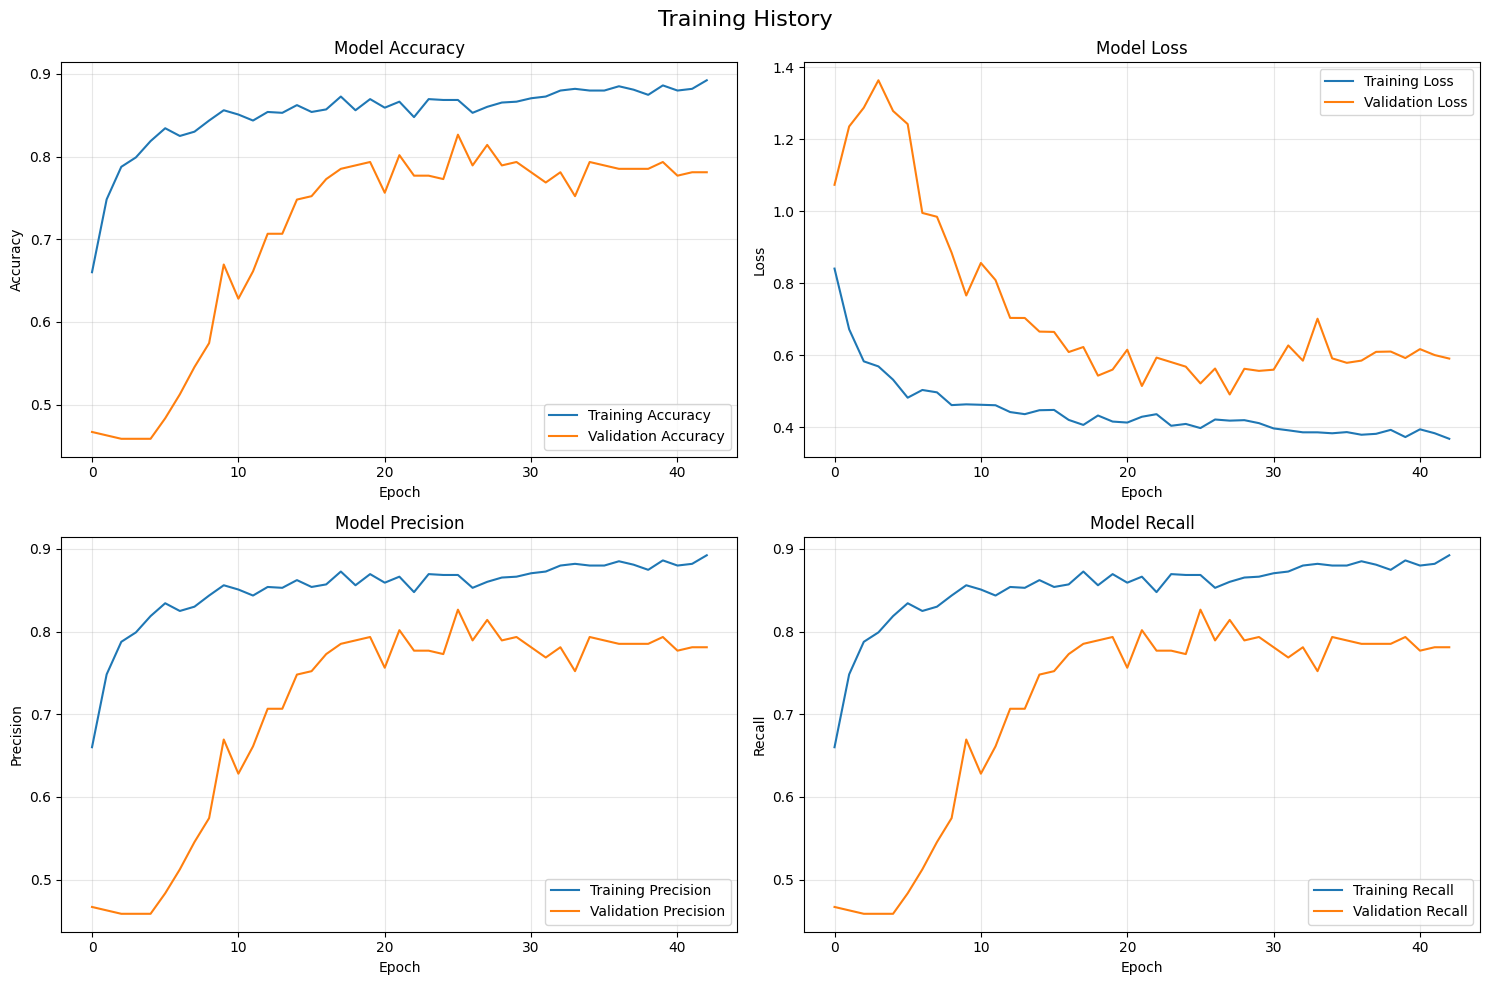

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training History', fontsize=16)

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Training Loss')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Model Evaluation

In [ ]:
# Make predictions
y_pred_proba = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate metrics
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test_reshaped, y_cat_test, verbose=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step
Test Accuracy: 0.8140
Test Precision: 0.8140
Test Recall: 0.8140
Test F1-Score: 0.8140
Test Accuracy: 0.8140
Test Precision: 0.8140
Test Recall: 0.8140
Test F1-Score: 0.8140


In [ ]:
# Detailed classification report
print("\nDetailed Classification Report:")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Detailed Classification Report:
                precision    recall  f1-score   support

     CANDIDATE       0.72      0.98      0.83       110
FALSE POSITIVE       0.98      0.67      0.80       132

      accuracy                           0.81       242
     macro avg       0.85      0.83      0.81       242
  weighted avg       0.86      0.81      0.81       242

                precision    recall  f1-score   support

     CANDIDATE       0.72      0.98      0.83       110
FALSE POSITIVE       0.98      0.67      0.80       132

      accuracy                           0.81       242
     macro avg       0.85      0.83      0.81       242
  weighted avg       0.86      0.81      0.81       242



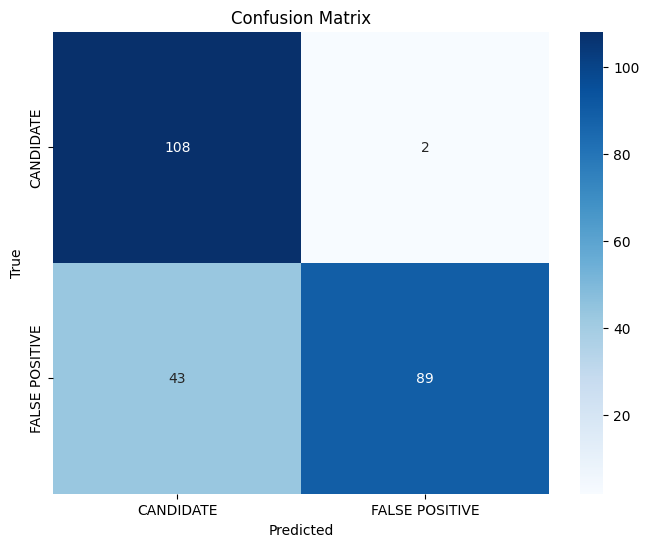


Confusion Matrix (Percentages):
True CANDIDATE -> Pred CANDIDATE: 98.2% (108 samples)
True CANDIDATE -> Pred FALSE POSITIVE: 1.8% (2 samples)
True FALSE POSITIVE -> Pred CANDIDATE: 32.6% (43 samples)
True FALSE POSITIVE -> Pred FALSE POSITIVE: 67.4% (89 samples)


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print confusion matrix with percentages
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis] * 100
print("\nConfusion Matrix (Percentages):")
for i, true_label in enumerate(label_encoder.classes_):
    for j, pred_label in enumerate(label_encoder.classes_):
        print(f"True {true_label} -> Pred {pred_label}: {cm_percent[i,j]:.1f}% ({cm[i,j]} samples)")

## ROC Curves and Performance Analysis

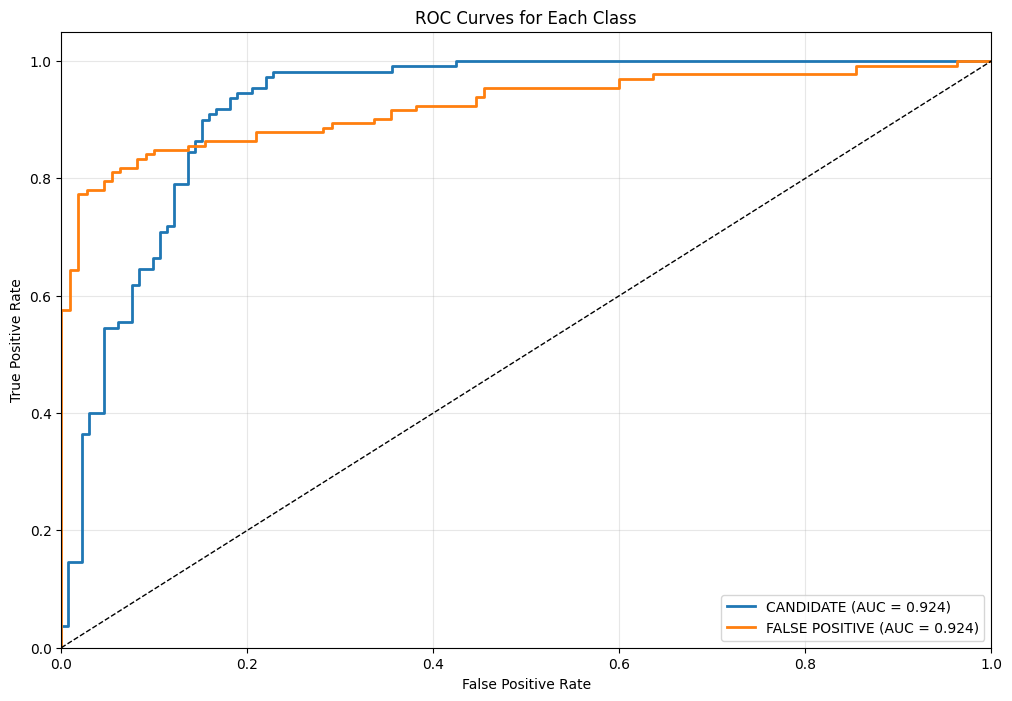

In [ ]:
# ROC curves for each class
plt.figure(figsize=(12, 8))

for i, class_name in enumerate(label_encoder.classes_):
    # Convert to binary classification for ROC curve
    y_test_binary = (y_test == i).astype(int)
    y_pred_proba_class = y_pred_proba[:, i]
    
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba_class)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, linewidth=2, 
             label=f'{class_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## Model Saving and Export

In [ ]:
# Save the final model
model.save('final_lightkurve_cnn_model.keras')
print("Final model saved as: final_lightkurve_cnn_model.keras")

# Save model metadata
model_metadata = {
    'input_shape': input_shape,
    'num_classes': num_classes,
    'class_names': label_encoder.classes_.tolist(),
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1_score': float(2 * (test_precision * test_recall) / (test_precision + test_recall)),
    'training_samples': int(len(X_train)),
    'testing_samples': int(len(X_test)),
    'total_samples': int(len(X))
}

import json
with open('lightkurve_model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print("Model metadata saved as: lightkurve_model_metadata.json")
print("\nModel Metadata:")
for key, value in model_metadata.items():
    print(f"{key}: {value}")

Final model saved as: final_lightkurve_cnn_model.keras
Model metadata saved as: lightkurve_model_metadata.json

Model Metadata:
input_shape: (3000, 1)
num_classes: 2
class_names: ['CANDIDATE', 'FALSE POSITIVE']
test_accuracy: 0.8140496015548706
test_precision: 0.8140496015548706
test_recall: 0.8140496015548706
test_f1_score: 0.8140496015548706
training_samples: 965
testing_samples: 242
total_samples: 1207


## Summary and Conclusions

In [ ]:
print("=" * 60)
print("LIGHTKURVE CNN MODEL TRAINING SUMMARY")
print("=" * 60)
print(f"Dataset: {len(X)} lightkurve samples")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"")
print(f"Classes: {', '.join(label_encoder.classes_)}")
print(f"")
print(f"Final Test Results:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")
print(f"")
print(f"Files created:")
print(f"  - lightkurve_train_metadata.csv (training data Kepler IDs and dispositions)")
print(f"  - lightkurve_test_metadata.csv (testing data Kepler IDs and dispositions)")
print(f"  - final_lightkurve_cnn_model.keras (trained model)")
print(f"  - best_lightkurve_model.keras (best model checkpoint)")
print(f"  - lightkurve_model_metadata.json (model metadata)")
print("=" * 60)

LIGHTKURVE CNN MODEL TRAINING SUMMARY
Dataset: 1207 lightkurve samples
Training samples: 965
Testing samples: 242

Classes: CANDIDATE, FALSE POSITIVE

Final Test Results:
  Accuracy:  0.8140
  Precision: 0.8140
  Recall:    0.8140
  F1-Score:  0.8140

Files created:
  - lightkurve_train_metadata.csv (training data Kepler IDs and dispositions)
  - lightkurve_test_metadata.csv (testing data Kepler IDs and dispositions)
  - final_lightkurve_cnn_model.keras (trained model)
  - best_lightkurve_model.keras (best model checkpoint)
  - lightkurve_model_metadata.json (model metadata)
